**Now, why is the python version different from the sys.version?**: sys.version gives the IPy kernel version, `!python --version` gives the REPL python version from which Jupyter notebook starts

## Load data & packages

In [1]:
# enable python linting
%load_ext nb_black

# input dataset
input_file = "../data/all_combined_training.csv"
validation_file = "../data/all_combined_validation.csv"

dfName = "df1"
processed_data = lambda dfName: "../data/" + dfName + "_processed.csv"

model_root = "../artifacts/models/"
data_root = "../data/"
fig_root = "../figs/"
package_root = "../packages/"
root = "../"
DEBUG_MODE = True

<IPython.core.display.Javascript object>

In [2]:
%%capture
import os
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import numpy as np
import pandas as pd
import scipy.stats as scs

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
# joblib still saves model in .pickle files
from joblib import dump, load
import xgboost as xgb

sns.set()
plt.style.use('bmh')

# There is a slight chance that I might have to run the following two lines for the local package to work
# import sys
# sys.path.insert(0, '..')

import warnings
warnings.filterwarnings('ignore')

from Preps import prep
Preprocessing = prep.Preprocessing()

<IPython.core.display.Javascript object>

In [4]:
# # load data
# df = pd.read_csv(processed_data(dfName="df1"), index_col=0)
# df.sample(2)

<IPython.core.display.Javascript object>

## Hourly resolution

In [5]:
# list_of_df = Preprocessing.load_dframes(
#     df_name="df", prop="_processed", data_root=data_root
# )

# for i in range(0, 9):
#     vars()["df" + str(i + 1) + "_processed"] = list_of_df[i]

# # ensure
# Preprocessing.show_shape([df1_processed, df2_processed, df9_processed])

<IPython.core.display.Javascript object>

In [44]:
df_name = "df5_processed"

<IPython.core.display.Javascript object>

In [45]:
df = Preprocessing.load_n_sort(df=df_name, data_root=data_root)
df

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
0,2013,1,1,0,251.996333,62.41657,-77.91644,414,384.150178,-18.053992,2013-01-01,0.608687,2013-01-01 00:00:00
1,2013,1,1,1,249.899333,62.41657,-77.91644,414,384.150178,-18.308829,2013-01-01,0.603622,2013-01-01 01:00:00
2,2013,1,1,2,242.710667,62.41657,-77.91644,414,384.150178,-18.255591,2013-01-01,0.586258,2013-01-01 02:00:00
3,2013,1,1,3,243.910167,62.41657,-77.91644,414,384.150178,-17.858344,2013-01-01,0.589155,2013-01-01 03:00:00
4,2013,1,1,4,240.110000,62.41657,-77.91644,414,384.150178,-17.727545,2013-01-01,0.579976,2013-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2015,12,31,19,341.500000,62.41657,-77.91644,414,384.150178,-18.821753,2015-12-31,0.824879,2015-12-31 19:00:00
26276,2015,12,31,20,350.100000,62.41657,-77.91644,414,384.150178,-18.433936,2015-12-31,0.845652,2015-12-31 20:00:00
26277,2015,12,31,21,328.900000,62.41657,-77.91644,414,384.150178,-18.406271,2015-12-31,0.794444,2015-12-31 21:00:00
26278,2015,12,31,22,305.800000,62.41657,-77.91644,414,384.150178,-19.032919,2015-12-31,0.738647,2015-12-31 22:00:00


<IPython.core.display.Javascript object>

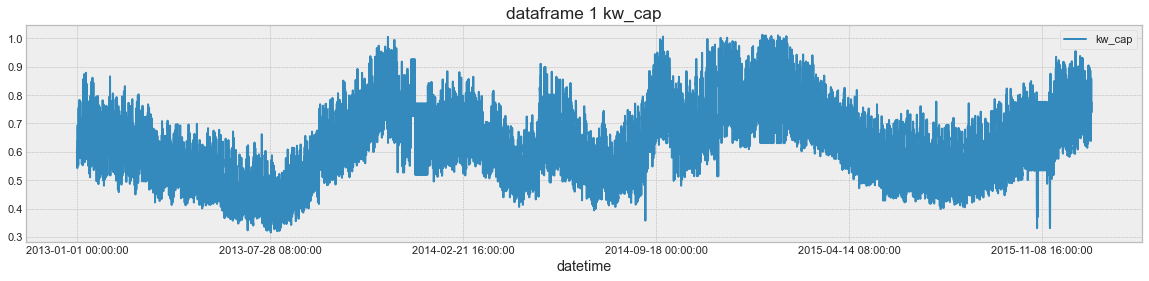

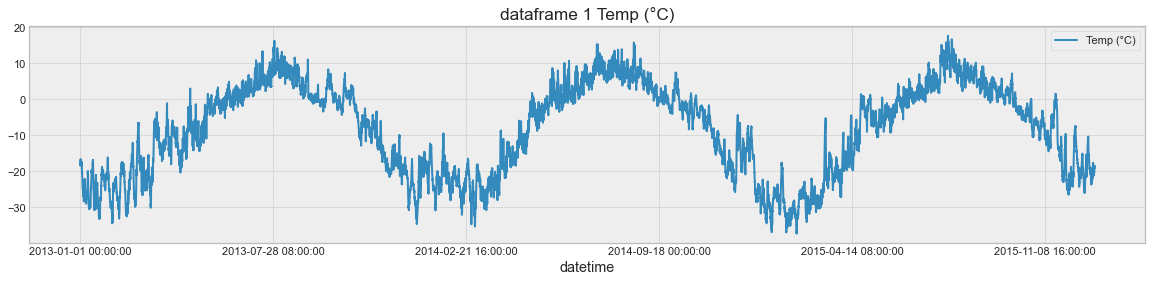

<IPython.core.display.Javascript object>

In [46]:
# plot_dfs() only plots kw_cap and temperature
Preprocessing.plot_dfs(dfs=[df], cols=["kw_cap", "Temp (°C)"])

## Scale and standardize the data

__The `temperature` and `kw_cap` seem *VERY* correlated__ once we plot them, but let's transform the two series before calculating the correlation. How about we scale them to `[0,1]`? 

In [9]:
# #  we scale kw_cap column to (0,1), and Temp column to range (0, 0.7)
# list_of_scaled_df = Preprocessing.scale_series(
#     list_of_df,
#     cols=["kw_cap", "Temp (°C)"],
#     cols_scaler_range=[(0, 1), (0, 0.7)],
#     DEBUG_MODE=False,
# )
# for i in range(len(list_of_scaled_df)):
#     vars()["df" + str(i + 1) + "_scaled"] = list_of_scaled_df[i]

# df6_scaled

<IPython.core.display.Javascript object>

In [10]:
# plt.figure(figsize=(18, 3))
# Preprocessing.plot_series(
#     range(len(df1_scaled.kw_cap)), df1_scaled.kw_cap, label="kw_cap_scaled"
# )
# Preprocessing.plot_series(
#     range(len(df1_scaled["Temp (°C)"])),
#     0.8 - df1_scaled["Temp (°C)"],
#     label=f"0.8 - temp_scaled",
# )

<IPython.core.display.Javascript object>

__Standardize the data__

In [11]:
# list_of_std_df = Preprocessing.standardize_series(
#     list_of_df[:3], cols=["kw_cap", "Temp (°C)"], DEBUG_MODE=True
# )

# # give the dataframe to designated vars
# for i in range(len(list_of_std_df)):
#     vars()["df" + str(i + 1) + "_stdard"] = list_of_std_df[i]

<IPython.core.display.Javascript object>

__Sanity check__: verify that the data mean and std are `0` and `1`

In [12]:
# dd = df2_stdard["kw_cap"].values.reshape(len(df2_stdard), 1)
# scaler = StandardScaler()
# scaler = scaler.fit(dd)
# print("Mean: %f, StandardDeviation: %f" % (scaler.mean_, sqrt(scaler.var_)))

<IPython.core.display.Javascript object>

## Let's find the correlation between two variables
* kw_cap ~ Temp
* kw_cap ~ year
* kw_cap ~ hour

Top 3 most correlated vars with  `kw_cap` are `Temp > hour > year`

In [13]:
# # df1_processed[["kw_cap", "Temp (°C)", "year", "month", "day", "hour"]].corr(method="pearson")
# df1_processed[["kw_cap", "Temp (°C)"]].corr(method="pearson")

<IPython.core.display.Javascript object>

In [14]:
# df1_stdard.corr()

<IPython.core.display.Javascript object>

__Correlation is the same regardless of the standardization, so we choose not to standardize__

In [15]:
# d_series = df1_stdard["kw_cap"]
# df1_processed["log_change"] = np.log(d_series / d_series.shift(1))
# Preprocessing.plot_QQ(df1_processed, "log_change")

<IPython.core.display.Javascript object>

In [16]:
# Preprocessing.plot_QQ(df1_stdard, "kw_cap")

<IPython.core.display.Javascript object>

## Scatter plot

In [17]:
# df1_stdard.plot(x="kw_cap", y="Temp (°C)", kind="scatter", figsize=(10, 5))
# # df1_processed.plot(x="kw_cap", y="hour", kind="scatter", figsize=(10, 5))
# # df1_processed.plot(x="kw_cap", y="year", kind="scatter", figsize=(10, 8))
# # df1_processed.plot(x="kw_cap", y="day", kind="scatter", figsize=(10, 8))
# # df1_processed.plot(x="kw_cap", y="annual_peak_load", kind="scatter", figsize=(10, 8))

<IPython.core.display.Javascript object>

## XGB Predictions

In [68]:
# df.columns
# # df1_processed.hour.value_counts()

<IPython.core.display.Javascript object>

In [69]:
train_data = df[: int(df.shape[0] * 0.8)]
test_data = df[int(df.shape[0] * 0.8) :]

drop_cols = [
    "kw_cap",
    "lat",
    "lon",
    "population",
    "annual_peak_load",
    "datetime",
    #     "log_change",
    "Kw",
    "date",
]
output_cols = ["kw_cap"]

X_train = train_data.copy().drop(columns=drop_cols)
X_test = test_data.copy().drop(columns=drop_cols)

y_train = train_data.copy()[output_cols]
y_test = test_data.copy()[output_cols]

<IPython.core.display.Javascript object>

__Just run once, the model is saved__

In [49]:
%%capture
xgb_r = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, seed=123)

xgb_r.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="mae",
)

xgb_r.save_model(model_root + "multivariate_xgb_regsr_" + df_name[:3] + ".json")

<IPython.core.display.Javascript object>

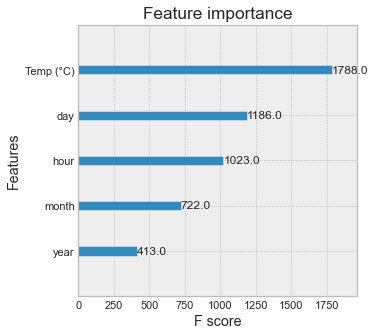

<IPython.core.display.Javascript object>

In [50]:
xgb_2 = xgb.XGBRegressor()
xgb_2.load_model(model_root + "multivariate_xgb_regsr_" + df_name[:3] + ".json")

xgb.plot_importance(xgb_2)
plt.rcParams["figure.figsize"] = [5, 5]
plt.show()

In [51]:
# Predictions on the train dataset
train_pred = xgb_2.predict(X_train)
# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_pred = xgb_2.predict(X_test)
# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Train RMSE : % f" % (train_rmse))
print("Test RMSE : % f" % (test_rmse))

Train RMSE :  0.031186
Test RMSE :  0.079960


<IPython.core.display.Javascript object>

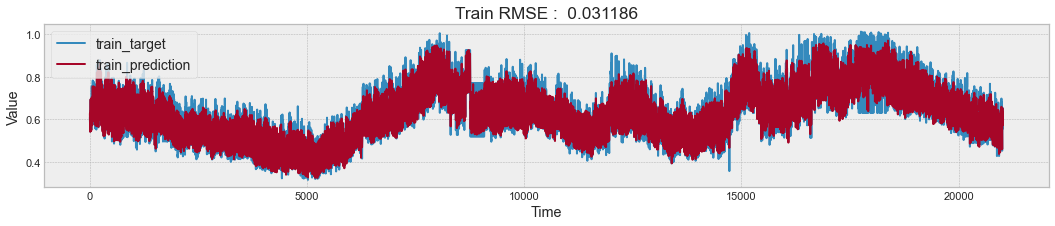

<IPython.core.display.Javascript object>

In [54]:
plt.figure(figsize=(18, 3))
target_s = pd.Series(y_train.kw_cap)[:]
pred_s = pd.Series(train_pred)[:]
plt.title("Train RMSE : % f" % (train_rmse))
Preprocessing.plot_series(range(len(target_s)), target_s, label="train_target")
Preprocessing.plot_series(range(len(pred_s)), pred_s, label=f"train_prediction")

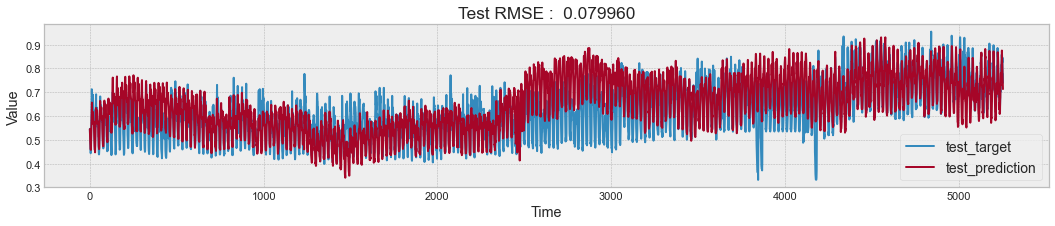

<IPython.core.display.Javascript object>

In [55]:
plt.figure(figsize=(18, 3))
target_s = pd.Series(y_test.kw_cap)[:]
pred_s = pd.Series(test_pred)[:]
plt.title("Test RMSE : % f" % (test_rmse))
Preprocessing.plot_series(range(len(target_s)), target_s, label="test_target")
Preprocessing.plot_series(range(len(pred_s)), pred_s, label=f"test_prediction")

In [56]:
X_train["Temp (°C) shift 1"] = X_train["Temp (°C)"].shift(
    periods=1, fill_value=X_train["Temp (°C)"].mean()
)
X_train["Temp (°C) shift 3"] = X_train["Temp (°C)"].shift(
    periods=3, fill_value=X_train["Temp (°C)"].mean()
)
X_train["Temp (°C) shift 5"] = X_train["Temp (°C)"].shift(
    periods=5, fill_value=X_train["Temp (°C)"].mean()
)
X_train["Temp (°C) shift 7"] = X_train["Temp (°C)"].shift(
    periods=7, fill_value=X_train["Temp (°C)"].mean()
)

X_test["Temp (°C) shift 1"] = X_test["Temp (°C)"].shift(
    periods=1, fill_value=X_test["Temp (°C)"].mean()
)
X_test["Temp (°C) shift 3"] = X_test["Temp (°C)"].shift(
    periods=3, fill_value=X_test["Temp (°C)"].mean()
)
X_test["Temp (°C) shift 5"] = X_test["Temp (°C)"].shift(
    periods=5, fill_value=X_test["Temp (°C)"].mean()
)
X_test["Temp (°C) shift 7"] = X_test["Temp (°C)"].shift(
    periods=7, fill_value=X_test["Temp (°C)"].mean()
)

X_test.head(2)
# X_train.head(2)

,year,month,day,hour,Temp (°C),Temp (°C) shift 1,Temp (°C) shift 3,Temp (°C) shift 5,Temp (°C) shift 7
21024,2015,5,27,0,-4.593115,-2.135404,-2.135404,-2.135404,-2.135404
21025,2015,5,27,1,-5.146826,-4.593115,-2.135404,-2.135404,-2.135404


<IPython.core.display.Javascript object>

In [57]:
# %%capture
xgb_r = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, seed=123)

xgb_r.fit(
    X_train,
    y_train,
    #     eval_set=[(X_train, y_train),(X_test, y_test)],
    eval_metric="mae",
)
# Predictions on the train dataset
train_pred = xgb_r.predict(X_train)
# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_pred = xgb_r.predict(X_test)
# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Train RMSE : % f" % (train_rmse))
print("Test RMSE : % f" % (test_rmse))

Train RMSE :  0.028885
Test RMSE :  0.072564


<IPython.core.display.Javascript object>

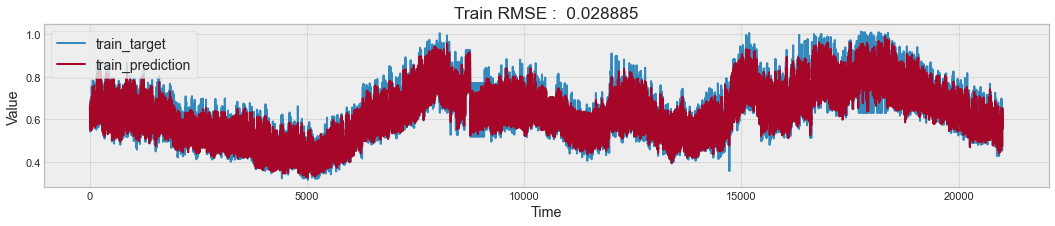

<IPython.core.display.Javascript object>

In [58]:
plt.figure(figsize=(18, 3))
target_s = pd.Series(y_train.kw_cap)[:]
pred_s = pd.Series(train_pred)[:]
plt.title("Train RMSE : % f" % (train_rmse))
Preprocessing.plot_series(range(len(target_s)), target_s, label="train_target")
Preprocessing.plot_series(range(len(pred_s)), pred_s, label=f"train_prediction")

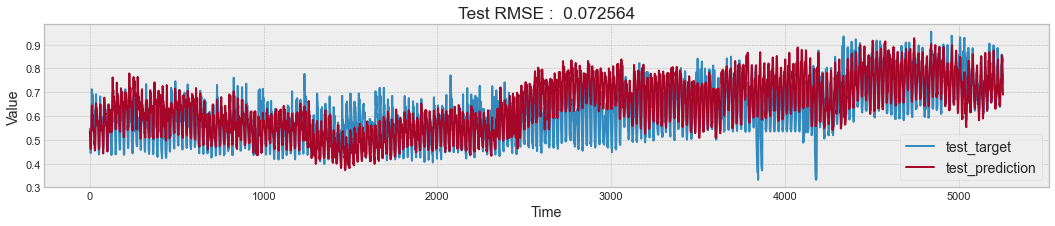

<IPython.core.display.Javascript object>

In [59]:
plt.figure(figsize=(18, 3))
target_s = pd.Series(y_test.kw_cap)[:]
pred_s = pd.Series(test_pred)[:]
plt.title("Test RMSE : % f" % (test_rmse))
Preprocessing.plot_series(range(len(target_s)), target_s, label="test_target")
Preprocessing.plot_series(range(len(pred_s)), pred_s, label=f"test_prediction")